 ## How much money you should take for your AirBnB listing as a host?
 This capstone project is using data from AirBnB. <br/> In particular each data point respresents one listing, rented out in Berlin, Germany.
 As a host you might want to know what is a reasonable price for your listing. This project builds a model which can suggest a price. <br/>

In [1]:
import os
from IPython import get_ipython
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)
import pandas_profiling as pp
import numpy as np
import datetime as dt   
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
import seaborn as sns
# Load models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.svm import SVR

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, power_transform, QuantileTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA 

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Data Source: https://www.kaggle.com/brittabettendorf/berlin-airbnb-data
df = pd.read_csv("data/berlin-airbnb-data/listings.csv")
# pp.ProfileReport(df, check_correlation=True).to_file(outputfile="Main/3.7_ProfileOfBerlinAirBnB_RAW.html")
# See the webpage at: https://github.com/RobKnop/ThinkfulDataScienceBootcamp/blob/master/Main/3.7_ProfileOfBerlinAirBnB_RAW.html

 ### Variable descriptions
 * id
 * name
 * host_id
 * host_name
 * neighbourhood_group
 * neighbourhood
 * latitude
 * longitude
 * room_type
 * price
 * minimum_nights
 * number_of_reviews
 * last_review
 * reviews_per_month
 * calculated_host_listings_count
 * availability_365

In [3]:
# Feature Engineering and Selection

# Rename our target variable (Y)
df['y_price'] = df['price']
# Transform the date variable into something a ML model can use. 
# In this case we calculate the number of days passed since the last review. After that we have an integer.
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_last_review'] = (df['last_review'] - dt.datetime(2018, 12, 31)).dt.days

# Drop unnecessary columns
df = df.drop(columns=[
    'name', # we won't do any NLP here
    'last_review', # already converted into 'days_since_last_review'
    'price', # was copied into 'y_price'
    'id', # just a increasing number
])

# Cleaning: Get rid of outliers
# Drop examples where 
# the price is higher than 400€ 
# and lower than 10€
df = df[df['y_price'] > 10] # 22522 - 22491 = 31 --> under 0.1% of all data
df = df[df['y_price'] < 400] # 22491 - 22374 = 117 --> 0.5% of all data
# remove all listings which require a minimum stay of more than 500 nights
df = df[df['minimum_nights'] < 500] # 22374 - 22368 = 6 --> under 0.1% of all data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


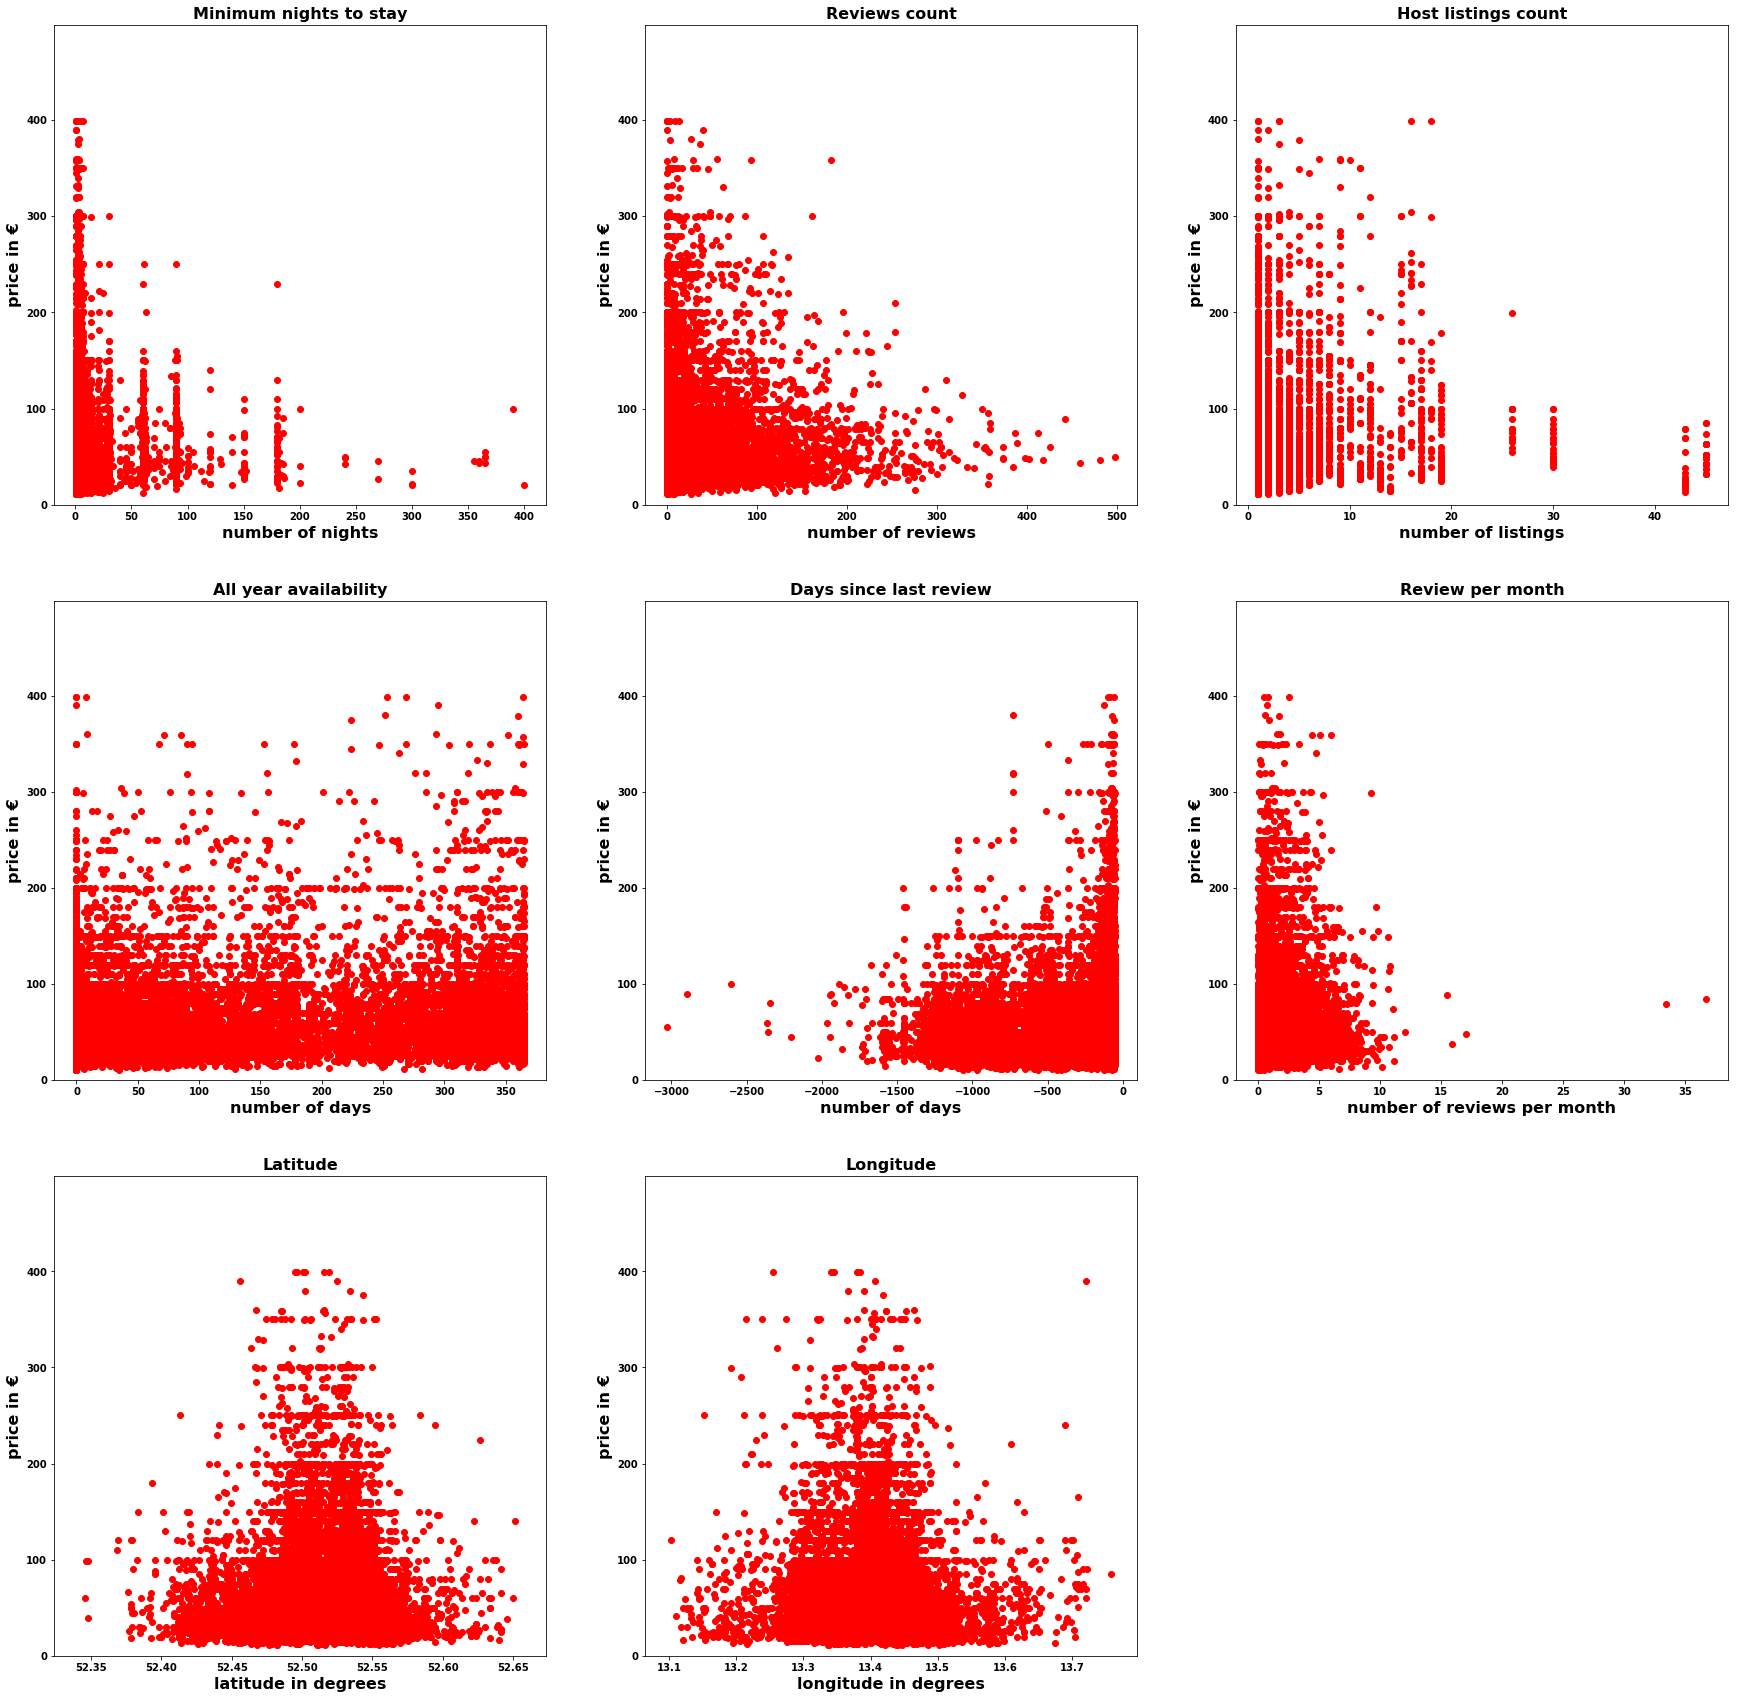

In [4]:
# See the relation of every numeric feature with the Y (price)
plt.figure(figsize=(30, 30),)

df.sort_values(by=['minimum_nights'])
plt.subplot(3, 3, 1)
plt.scatter(df['minimum_nights'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of nights', font)
plt.title('Minimum nights to stay', font)

df.sort_values(by=['number_of_reviews'])
plt.subplot(3, 3, 2)
plt.scatter(df['number_of_reviews'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of reviews', font)
plt.title('Reviews count', font)

df.sort_values(by=['calculated_host_listings_count'])
plt.subplot(3, 3, 3)
plt.scatter(df['calculated_host_listings_count'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of listings', font)
plt.title('Host listings count', font)

df.sort_values(by=['availability_365'])
plt.subplot(3, 3, 4)
plt.scatter(df['availability_365'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of days', font)
plt.title('All year availability', font)

df.sort_values(by=['days_since_last_review'])
plt.subplot(3, 3, 5)
plt.scatter(df['days_since_last_review'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of days', font)
plt.title('Days since last review', font)

df.sort_values(by=['reviews_per_month'])
plt.subplot(3, 3, 6)
plt.scatter(df['reviews_per_month'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of reviews per month', font)
plt.title('Review per month', font)

plt.subplot(3, 3, 7)
plt.scatter(df['latitude'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('latitude in degrees', font)
plt.title('Latitude', font)

plt.subplot(3, 3, 8)
plt.scatter(df['longitude'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('longitude in degrees', font)
plt.title('Longitude', font)

plt.show()

 #### Plot interpretation
 Except "availability_365" all other features show some kind of pattern or releation.

                                host_id  latitude  longitude  minimum_nights  \
host_id                            1.00      0.01      -0.04           -0.06   
latitude                           0.01      1.00      -0.11            0.02   
longitude                         -0.04     -0.11       1.00           -0.06   
minimum_nights                    -0.06      0.02      -0.06            1.00   
number_of_reviews                 -0.15      0.04      -0.02           -0.04   
reviews_per_month                  0.18      0.04      -0.04           -0.08   
calculated_host_listings_count    -0.05      0.04      -0.04            0.06   
availability_365                  -0.01      0.01      -0.08            0.18   
y_price                           -0.02      0.05      -0.04           -0.00   
days_since_last_review             0.18      0.02      -0.04           -0.05   

                                number_of_reviews  reviews_per_month  \
host_id                                     -0.

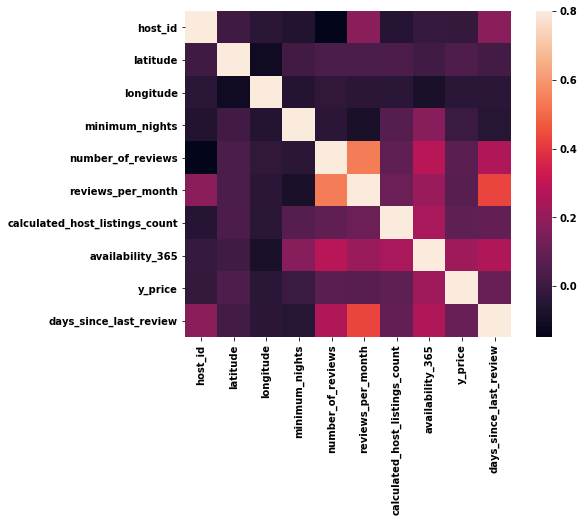

In [5]:
# Cleaning: Fill NaNs
values_to_fill = {
    'days_since_last_review': df.days_since_last_review.mean(), 
    'reviews_per_month': df.reviews_per_month.mean(),
    'latitude': df.latitude.mean(),
    'longitude': df.longitude.mean()
    }
df = df.fillna(value=values_to_fill)

# Do second data profile report on the cleaned data
## pp.ProfileReport(df, check_correlation=True, pool_size=15).to_file(outputfile="Main/3.7_ProfileOfBerlinAirBnB_CLEAN.html")
# See the webpage at: https://github.com/RobKnop/ThinkfulDataScienceBootcamp/blob/master/Main/3.7_ProfileOfBerlinAirBnB_CLEAN.html

# Check for correlation
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

 #### Findings
 1. Correlation to y (price) is low: < 0.22
 2. Multicollinearity is low

 #### Our key evaluation metric to optimize on is root mean squared error

 #### Models to try:
 1. Linear Regression (Lasso and Ridge)
 4. RandomForestRegressor
 5. KNN
 6. Support Vector Machine
 7. GradientBoosting Regression
 8. (Also use of KSelectBest, GridSearch, PCA)

In [6]:
# Normalize
mm_scaler = MinMaxScaler()
df[['longitude']] = mm_scaler.fit_transform(df[['longitude']].values)
df[['latitude']] = mm_scaler.fit_transform(df[['latitude']].values)
df[['minimum_nights']] = mm_scaler.fit_transform(df[['minimum_nights']].values)
df[['number_of_reviews']] = mm_scaler.fit_transform(df[['number_of_reviews']].values)
df[['reviews_per_month']] = mm_scaler.fit_transform(df[['reviews_per_month']].values)
df[['availability_365']] = mm_scaler.fit_transform(df[['availability_365']].values)
df[['calculated_host_listings_count']] = mm_scaler.fit_transform(df[['calculated_host_listings_count']].values)
df[['days_since_last_review']] = mm_scaler.fit_transform(df[['days_since_last_review']].values)

# Define X and y
X = df.drop(columns=[
                    'y_price', # is the Y
                    'neighbourhood_group', # is categorical 
                    'neighbourhood', # is categorical 
                    'room_type', # is categorical 
                    'host_id', # it should not be an input, model should suggest a price independent of the host id 
                    'host_name' # a name should not be a good predictor (also add bias)
                    ])
X = pd.concat([X, pd.get_dummies(df['neighbourhood_group'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['neighbourhood'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['room_type'])], axis=1)

# Try power_transform (cox-box or yoe-johnson) instaed of MinMaxScaler
# X_trans = power_transform(X, method='yeo-johnson')
# Did not work better!

y = df['y_price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# Linear Regression: Instantiate and fit our model.
regr = linear_model.Ridge(alpha=.2)
#print(data['Sales'].values)

regr.fit(X_train, y_train)

# Inspect the results.
y_pred = regr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('R^2 score: ', regr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1209.1279816547512
    rms error is: 34.77251762030974
    R^2 score:  0.2964557691054268

PCA:
    mean-squared: 1352.2922436354918
    rms error is: 36.77352639651918
    R^2 score:  0.2734677236923385
    Cross Validated Score: -5620486015875508338688.00 (+/- 22481944014540442173440.00)
'''
# Cross validate
score = cross_val_score(regr, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (np.sqrt(-1 * score.mean()), np.sqrt(score.std()) * 2))


mean-squared: 1209.1279816547512
rms error is: 34.77251762030974
R^2 score:  0.2964557691054268


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross Validated Score: 34.66 (+/- 24.83)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


In [8]:
# See the impact of each feature
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients.columns = ['feature', 'coef_value']
coefficients.sort_values(by=['coef_value'], ascending=False)

,feature,coef_value
63,Haselhorst,46.42
123,Rummelsburger Bucht,34.30
118,Rahnsdorf/Hessenwinkel,34.25
119,Regierungsviertel,33.18
76,Kurfürstendamm,32.58
128,Schmöckwitz/Karolinenhof/Rauchfangswerder,29.90
88,Marienfelde,28.62
155,Entire home/apt,27.12
138,Tiergarten Süd,25.26
7,days_since_last_review,24.26


In [9]:
# KNN:
for k in range(22, 30, 1):
    print('\nk = ', k)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print('mean-squared:', mean_squared_error(y_test, y_pred))
    rmse_val = rmse(y_pred, y_test)
    print("rms error is: " + str(rmse_val))
    print('KNN R^2 score: ', knn.score(X_test, y_test))
    
    knn_w = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_w.fit(X_train, y_train)
    y_pred = knn_w.predict(X_test)
    print('\nmean-squared:', mean_squared_error(y_test, y_pred))
    rmse_val = rmse(y_pred, y_test)
    print("rms error is: " + str(rmse_val))
    print('KNN_dist R^2 score: ', knn_w.score(X_test, y_test))


k =  22
mean-squared: 1231.0662417752526
rms error is: 35.08655357505568
KNN R^2 score:  0.28369075450166226

mean-squared: 1174.4677923080123
rms error is: 34.27050907570549
KNN_dist R^2 score:  0.31662317621748426

k =  23
mean-squared: 1232.3331054536484
rms error is: 35.10460234005861
KNN R^2 score:  0.28295361612939063

mean-squared: 1174.0571083900932
rms error is: 34.26451675407218
KNN_dist R^2 score:  0.31686213710959577

k =  24
mean-squared: 1232.570258561814
rms error is: 35.107979984069345
KNN R^2 score:  0.28281562602113064

mean-squared: 1173.7629480679018
rms error is: 34.26022399325348
KNN_dist R^2 score:  0.3170332974836636

k =  25
mean-squared: 1230.293741260617
rms error is: 35.07554334947097
KNN R^2 score:  0.2841402423050057

mean-squared: 1172.0965001838647
rms error is: 34.23589490847092
KNN_dist R^2 score:  0.3180029382600653

k =  26
mean-squared: 1233.580463255152
rms error is: 35.122364146724976
KNN R^2 score:  0.28222782746315833

mean-squared: 1173.765467

In [12]:
# Run best KNN model
k = 25
knn_w = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn_w.fit(X_train, y_train)
# Inspect the results.
y_pred = knn_w.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('R^2 score: ', knn_w.score(X_test, y_test))
"""
Weighted:
    mean-squared: 1172.0965001838647
    rms error is: 34.23589490847092
    KNN_dist R^2 score:  0.3180029382600653
"""
# Cross validate
score = cross_val_score(knn_w, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (np.sqrt(-1 * score.mean()), np.sqrt(score.std()) * 2))


mean-squared: 1172.0965001838647
rms error is: 34.23589490847092
R^2 score:  0.3180029382600653


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross Validated Score: 35.02 (+/- 25.69)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.0s finished


In [13]:
# RandomForestRegressor:
rfr = ensemble.RandomForestRegressor(n_jobs=-1, verbose=1)

# Choose some parameter combinations to try
parameters = {'n_estimators': [16, 32, 64, 96], 
              #'max_features': ['log2', 'sqrt','auto'], 
              #'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 13, 16], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(rfr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 26.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    5.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [14]:
# Run best RandomForestRegressor model:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('RandomForest R^2 score: ', rfr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1114.9156553846422
    rms error is: 33.390352729263654
    RandomForest R^2 score:  0.3760057393460754
    Cross Validated Score: 0.32 (+/- 0.08)
SelectKBest(120):
    mean-squared: 1117.430849408185
    rms error is: 33.42799499533566
    RandomForest R^2 score:  0.374598039465334
    Cross Validated Score: 0.32 (+/- 0.09)
'''
# Cross validate
score = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (np.sqrt(-1 * score.mean()), np.sqrt(score.std()) * 2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.0s finished



mean-squared: 1082.285166976339
rms error is: 32.89810278688331
RandomForest R^2 score:  0.37026063662267483


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross Validated Score: 33.64 (+/- 25.29)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s finished


In [15]:
#SVM: 
svr = SVR(
        kernel='rbf', 
        degree=3, 
        gamma='scale', 
        coef0=0.0, tol=0.001, 
        C=1.0, 
        epsilon=0.1, 
        shrinking=True, 
        cache_size=200, 
        verbose=1, 
        max_iter=-1
        )

svr.fit(X_train, y_train) 
y_pred = svr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('SVM R^2 score: ', svr.score(X_test, y_test)) 
'''
mean-squared: 1361.019941403448
rms error is: 36.89200375966922
SVM R^2 score:  0.20807578483426692
Cross Validated Score: 0.21 (+/- 0.09)
'''
# Cross validate
score = cross_val_score(svr, X, y, cv=5, n_jobs=-1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[LibSVM]
mean-squared: 1361.019941403448
rms error is: 36.89200375966922
SVM R^2 score:  0.20807578483426692
Cross Validated Score: 0.21 (+/- 0.09)


In [16]:
#Gradient Boosting
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, n_iter_no_change=50, learning_rate=0.3)

# Choose some parameter combinations to try
parameters = {
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5, 7],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(gbr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 28.2min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
# Run the best Gradient Boosting model: 
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('Gradient Boost R^2 score: ', gbr.score(X_test, y_test))
'''
Plain:
    mean-squared: 1142.1625258267968
    rms error is: 33.795895103204415
    Gradient Boost R^2 score:  0.3607562532575337
    Cross Validated Score: 0.31 (+/- 0.07)
'''
# Cross validate
score = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (np.sqrt(-1 * score.mean()), np.sqrt(score.std()) * 2))


mean-squared: 1169.2817289430454
rms error is: 34.194761717886635
Gradient Boost R^2 score:  0.31964074343686405


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross Validated Score: 33.88 (+/- 25.43)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [21]:
#Try SelectKBest
# X_selKBest = SelectKBest(k=120).fit_transform(X, y)

# Use PCA (but it is not working better)
sklearn_pca = PCA(n_components=100)
X_pca = sklearn_pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=20)

In [22]:
# Gradient Boosting: 
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=7,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('Gradient Boost R^2 score: ', gbr.score(X_test, y_test))
'''
Plain:
    mean-squared: 1142.1625258267968
    rms error is: 33.795895103204415
    Gradient Boost R^2 score:  0.3607562532575337
    Cross Validated Score: 0.31 (+/- 0.07)s
SelectKBest:
    mean-squared: 1122.9432515976998
    rms error is: 33.51034544133651
    Gradient Boost R^2 score:  0.37151286677800033
    Cross Validated Score: 0.31 (+/- 0.07)
PCA:
    mean-squared: 1317.735332331002
    rms error is: 36.30062440690248
    Gradient Boost R^2 score:  0.29203376335601083
    Cross Validated Score: 0.29 (+/- 0.12)
'''
# Cross validate
score = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (np.sqrt(-1 * score.mean()), np.sqrt(score.std()) * 2))

      Iter       Train Loss   Remaining Time 
         1        1453.9712            2.54m
         2        1323.6153            3.12m
         3        1249.2871            3.11m
         4        1208.1241            3.03m
         5        1180.2471            3.34m
         6        1159.3802            3.90m
         7        1140.4825            4.28m
         8        1127.7558            4.11m
         9        1115.8552            3.92m
        10        1106.7600            3.96m
        20        1045.1515            3.66m
        30        1007.6701            3.90m
        40         984.3314            3.33m
        50         961.0756            2.95m
        60         934.0518            2.68m
        70         908.9680            2.48m
        80         888.6398            2.32m
        90         875.0281            2.18m
       100         858.7665            2.06m

mean-squared: 1141.1476076241709
rms error is: 33.78087635962351
Gradient Boost R^2 score:  0.3360

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross Validated Score: 33.87 (+/- 25.40)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


#### Final model evaluation:
 
The Linear Regression Model (Ridge) is our base model. Every other model is more complex and they have been only  considered if they performed better than Linear Regression.
This why the SVM model did not get further tuning time, because is was already worse than our base model.

KNN is not really the right algorithm for this experiment. With a lots of datapoint the inference is computationally inefficient. Additionally KNN is overfitting more: cross validated rmse 35.02 (+/- 25.66) - 10 folds

#### In the end only Random Forest and Gradient Boosting are left for further consideration.
But both models overfit more than our base model and they are also not interpretable because they have some randomness built in.

#### Winning model
The winning model is our Ridge Regressor. It overfits the least and it is the least complex model.
The performance is almost as good as the other models.
So there is no value to increase complexity to get marginal better results. That why the Ridge Regression fits best here. 

#### More things to do:
* Use Log scale
* Statsmodel
* Residual errors high and low prices 
* keep an eye on Class inbalance 
* Logistic regression, box them, 5 classes
* check with ROC characters and weighted matrix 